# K-Means Clustering for Call-Center Calls
**Goal:** cluster calls into segments, then identify which clusters have higher probability of RPC (Right Party Contact).
This notebook demonstrates the full thought process: definition, formula, preprocessing, how to choose `K`, diagnostics, visualization, and interpretation.

**Outline**
1. Definition & formula
2. Quick EDA
3. Preprocessing and feature selection (important decisions)
4. Standardization / PCA (optional)
5. Choosing K: Elbow + Silhouette
6. Fit K-Means, analyze clusters
7. Add `cluster` to dataset and compute RPC rate per cluster
8. Conclusion & next steps (prepare for XGBoost)


## 1) What is K-Means? (definition + formula)
K-Means is an unsupervised algorithm that partitions `n` observations into `K` clusters by minimizing *within-cluster* sum of squares (WCSS).

Objective: 

\[
\min_{C_1,\dots,C_K} \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
\]
where \(\mu_k\) is the centroid (mean) of cluster \(C_k\).

**Important notes**
- K-Means assumes roughly spherical clusters and uses Euclidean distance.
- Sensitive to feature scaling — **standardize numeric features** before clustering.
- Initialization sensitive: `kmeans++` is recommended.
- It does not handle categorical data natively — convert or encode appropriately.


## 2) Things to be mindful of (practical checklist)
- **Feature engineering**: remove IDs, avoid leakage (don’t use `rpc_prob` if present), consider aggregations (e.g., agent frequency).
- **Collinearity**: highly correlated features can distort centroids; consider PCA or drop redundant features.
- **Dimensionality**: K-Means degrades in very high dimensions (curse of dimensionality). Use PCA to reduce dimensionality if needed.
- **Scaling**: always scale numeric features (StandardScaler).
- **K selection**: use Elbow + Silhouette; validate cluster business meaning.
- **Stability**: try multiple `n_init` and random seeds to ensure stable clusters.


In [112]:
# 3) Imports and load data
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

# Set plotting aesthetics
sns.set(style="whitegrid", palette="muted", context="notebook")
plt.rcParams['figure.figsize'] = (8, 5)

# Path to your dataset (update if needed)
data_path = '../data/synthetic_callcenter_accounts.csv' 

# Load
df = pd.read_csv(data_path)
print("Loaded dataset with shape:", df.shape)
df.head()


Loaded dataset with shape: (20000, 27)


,call_id,customer_id,agent_id,agent_team,agent_skill,channel,queue,call_start,call_end,wait_time_sec,...,cost_usd,revenue_usd,contactability_score,account_age_days,prior_calls_30d,duration_sec,date,day_of_week,hour,week
0,8168,102402,549,South,Billing,phone,Billing,2025-01-01 00:55:43,2025-01-01 00:57:14,24,...,1.34,0.00,0.5142,1658,1,91,2025-01-01,Wednesday,0,1
1,10438,106097,533,West,Billing,phone,Sales,2025-01-01 01:02:44,2025-01-01 01:04:47,26,...,1.62,26.51,0.0448,1104,2,123,2025-01-01,Wednesday,1,1
2,13866,106222,549,South,Billing,phone,Retention,2025-01-01 01:36:04,2025-01-01 01:37:16,20,...,1.44,0.00,0.0695,720,0,72,2025-01-01,Wednesday,1,1
3,19658,105162,558,North,Sales,phone,Technical Support,2025-01-01 03:46:42,2025-01-01 03:49:49,20,...,5.01,0.00,0.0447,101,0,187,2025-01-01,Wednesday,3,1
4,1889,102632,517,North,Sales,email,Billing,2025-01-01 04:24:13,2025-01-01 04:26:25,32,...,2.00,0.00,0.0919,1788,1,132,2025-01-01,Wednesday,4,1


### Quick data preview / target
We expect a binary column `rpc_label` or `rpc`. If neither exists, we can't evaluate cluster → RPC relationship yet.


In [113]:
# 4) Quick checks: target and missingness
target_col = None
for c in ['rpc_label', 'rpc', 'RPC', 'rpc_label']:
    if c in df.columns:
        target_col = c
        break

print("Target column:", target_col)
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))


Target column: rpc_label

Missing values per column:
call_id                 0
customer_id             0
agent_id                0
agent_team              0
agent_skill             0
channel                 0
queue                   0
call_start              0
call_end                0
wait_time_sec           0
handle_time_sec         0
hold_time_sec           0
transfers               0
outcome                 0
satisfaction            0
segment                 0
rpc_label               0
cost_usd                0
revenue_usd             0
contactability_score    0
dtype: int64


## 5) Preprocessing decisions (explain in notebook)
- Keep numeric features that describe accounts (call_duration, num_attempts, fare-like features, account age, etc.).  
- Encode `agent_id` as frequency (high-cardinality), not one-hot.  
- Remove identifiers and any column that leaks target information (e.g., `rpc_prob`).  
- Impute numeric missing values with median (robust).  
- For categorical features with low cardinality we could one-hot encode; for the clustering step we will prefer numeric-only clustering to keep Euclidean metric meaningful.


In [114]:
# 6) Basic preprocessing function (clean & prepare numeric matrix for clustering)
def prepare_for_clustering(df, target_col=None, drop_cols=None, agent_col='agent_id'):
    df = df.copy()
    # drop obvious identifiers and user-specified drop columns
    if drop_cols is None:
        drop_cols = []
    possible_ids = [c for c in df.columns if c.lower().endswith('id') and c!=agent_col]
    to_drop = set(possible_ids + drop_cols)
    # drop any rpc_prob or other leakage columns
    for c in df.columns:
        if 'rpc_prob' in c.lower() or 'leak' in c.lower():
            to_drop.add(c)
    df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True, errors='ignore')
    
    # frequency encode agent_id
    if agent_col in df.columns:
        freq = df[agent_col].value_counts(normalize=True)
        df['agent_id_freq'] = df[agent_col].map(freq).fillna(0.0)
    
    # select numeric columns
    num_df = df.select_dtypes(include=[np.number]).copy()
    # remove target if present
    if target_col in num_df.columns:
        num_df.drop(columns=[target_col], inplace=True)
    # Impute numeric NA with median
    imputer = SimpleImputer(strategy='median')
    num_arr = imputer.fit_transform(num_df)
    num_df = pd.DataFrame(num_arr, columns=num_df.columns, index=num_df.index)
    return df, num_df, imputer

# Apply
df_raw = df.copy()
df_clean, num_df, imputer = prepare_for_clustering(df_raw, target_col=target_col, drop_cols=[])
print("Numeric features used for clustering:", num_df.columns.tolist())
num_df.shape


Numeric features used for clustering: ['agent_id', 'wait_time_sec', 'handle_time_sec', 'hold_time_sec', 'transfers', 'satisfaction', 'cost_usd', 'revenue_usd', 'contactability_score', 'account_age_days', 'prior_calls_30d', 'duration_sec', 'hour', 'week', 'agent_id_freq']
 ['agent_id', 'wait_time_sec', 'handle_time_sec', 'hold_time_sec', 'transfers', 'satisfaction', 'cost_usd', 'revenue_usd', 'contactability_score', 'account_age_days', 'prior_calls_30d', 'duration_sec', 'hour', 'week', 'agent_id_freq']


(20000, 15)

## 6.1 Check collinearity 
If many variables are highly correlated, we might remove some or use PCA.


In [115]:
# correlation matrix (sample if very large)
corr = num_df.corr().abs()
# show pairs with high correlation
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
high_corr_pairs.head(10)


handle_time_sec       cost_usd           0.928083
                      duration_sec       0.887744
cost_usd              duration_sec       0.847739
wait_time_sec         hold_time_sec      0.527613
                      duration_sec       0.466475
hold_time_sec         duration_sec       0.302375
contactability_score  prior_calls_30d    0.269906
cost_usd              revenue_usd        0.177243
wait_time_sec         revenue_usd        0.107401
                      satisfaction       0.096787
dtype: float64

**If you see very high correlation (>0.9) among predictors**, consider:
- dropping one of the pair, or
- applying PCA to reduce dimension and remove redundancy (we show PCA option below).


In [116]:
# 7) Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)
print("Scaled shape:", X_scaled.shape)


Scaled shape: (20000, 15)


## 8) Do we need PCA?
- If `num_features` is modest (< 10–20), PCA may not be necessary.
- If many features or strong multicollinearity, PCA reduces dimensionality and often helps K-Means.

We'll compute explained variance and optionally reduce to 2–6 components for clustering diagnostics.


In [117]:
# PCA exploration
n_features = X_scaled.shape[1]
pca = PCA(n_components=min(n_features, 10))
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()
explained


array([0.19409108, 0.29875462, 0.38344726, 0.45333229, 0.52238723,
       0.59030578, 0.65688695, 0.72292609, 0.78820273, 0.85149792])

Interpretation: choose the number of components that capture ~80–95% variance if you want dimensionality reduction.
If we reduce to PCA for clustering, we'll cluster on the PCA-transformed data.


In [118]:
# Optional: choose to use PCA-transformed space for KMeans (toggle)
USE_PCA = False   # set True if you want to cluster on PCA components
PCA_N_COMPONENTS = 5

if USE_PCA:
    pca_full = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
    X_for_clustering = pca_full.fit_transform(X_scaled)
    print(f"Using PCA: {PCA_N_COMPONENTS} components, shape: {X_for_clustering.shape}")
else:
    X_for_clustering = X_scaled
    print("Using scaled numeric features for clustering, shape:", X_for_clustering.shape)


Using scaled numeric features for clustering, shape: (20000, 15)


**How to read these plots**
- Elbow: find the 'knee' where inertia reduction slows — trade-off between complexity and compact clusters.
- Silhouette: higher is better (max 1). Values near 0 indicate overlapping clusters; negative means misassignment.
Choose a K that balances the elbow and a reasonably high silhouette.


In [119]:
# 10) Fit final KMeans
# Choose K based on above. For demonstration we pick K=3 (adjust if your plots suggest another)
K_FINAL = 3

kmeans_final = KMeans(n_clusters=K_FINAL, n_init=100, random_state=42, init='k-means++')
cluster_labels = kmeans_final.fit_predict(X_for_clustering)

# attach to dataframe
df_clustered = df_clean.copy()
df_clustered['cluster'] = cluster_labels

# cluster centers (if using PCA, transform centers back to original space if needed)
if USE_PCA:
    centers = pca_full.inverse_transform(kmeans_final.cluster_centers_)
else:
    centers = kmeans_final.cluster_centers_
centers_df = pd.DataFrame(centers, columns=num_df.columns)
centers_df.index.name = 'cluster'
centers_df


,agent_id,wait_time_sec,handle_time_sec,hold_time_sec,transfers,satisfaction,cost_usd,revenue_usd,contactability_score,account_age_days,prior_calls_30d,duration_sec,hour,week,agent_id_freq
cluster,,,,,,,,,,,,,,,
0,0.007074,-0.346631,-0.403286,-0.311429,-0.044128,0.037868,-0.415409,0.087707,0.007607,0.007035,-0.001027,-0.523567,0.001888,-0.007783,0.006395
1,-0.023814,-0.064329,1.534462,-0.196845,0.144394,-0.012868,1.517275,-0.174546,-0.036718,-0.005999,-0.016209,1.311784,-0.035435,0.033389,0.005832
2,-0.001422,1.752368,-0.160602,1.764439,0.014555,-0.164251,-0.078901,-0.182603,0.013653,-0.025583,0.027085,0.721288,0.039360,-0.008258,-0.038677


In [120]:
# sizes
sizes = df_clustered['cluster'].value_counts().sort_index()
print("Cluster sizes:\n", sizes)

# cluster means (for numeric features) — helpful to interpret what each cluster represents
cluster_profile = df_clustered.groupby('cluster')[num_df.columns].mean().T
cluster_profile.head(12)


Cluster sizes:
 cluster
0    13400
1     3815
2     2785
Name: count, dtype: int64


cluster,0,1,2
agent_id,529.662015,529.130275,529.533573
wait_time_sec,30.073955,39.218087,97.991741
handle_time_sec,98.906567,231.988991,115.575224
hold_time_sec,0.166418,0.850328,12.560862
transfers,0.137388,0.212844,0.161221
satisfaction,3.931269,3.893578,3.777738
cost_usd,2.302871,6.191389,2.979063
revenue_usd,3.905504,1.183085,1.102036
contactability_score,0.202351,0.196917,0.203182
account_age_days,1034.540970,1027.099345,1016.352603


In [121]:
# If rpc target exists, show RPC rate by cluster
if target_col:
    df_clustered['_rpc_label'] = df_raw[target_col].astype(int)  # original target
    rpc_by_cluster = df_clustered.groupby('cluster')['_rpc_label'].agg(['count','sum','mean']).rename(columns={'sum':'rpc_count','mean':'rpc_rate'})
    rpc_by_cluster = rpc_by_cluster.sort_values(by='rpc_rate', ascending=False)
    rpc_by_cluster
else:
    print("No rpc target found; cannot compute RPC rates yet.")


**Interpretation notes**
- Clusters with higher `rpc_rate` are the ones we might prioritize for dialing — more likely to reach the right party.
- Examine cluster profiles (means) to understand why one cluster has higher RPC (e.g., shorter time-since-last-contact, certain regions, agent frequency etc.).


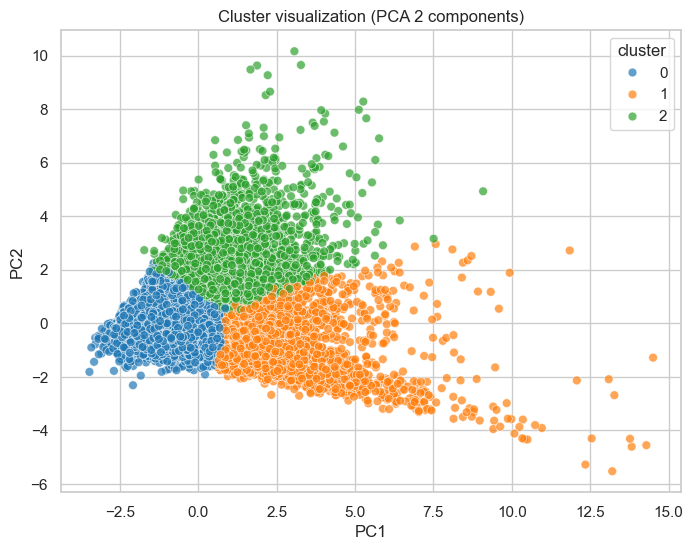

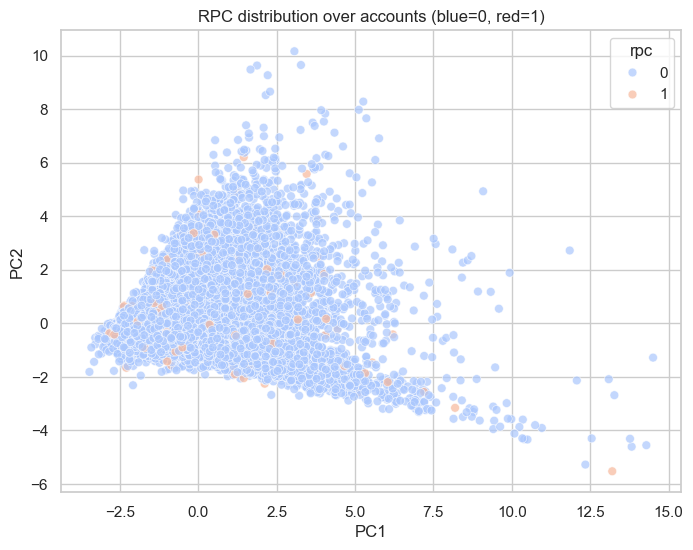

In [122]:
# 12) Visualize clusters (2D) with PCA for illustration
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_scaled)   # always use full scaled features for visualization
vis_df = pd.DataFrame(X_vis, columns=['PC1','PC2'], index=df_clustered.index)
vis_df['cluster'] = df_clustered['cluster'].astype(str)
vis_df['rpc'] = df_raw[target_col] if target_col else np.nan

plt.figure(figsize=(8,6))
sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.7, s=40)
plt.title('Cluster visualization (PCA 2 components)')
plt.legend(title='cluster')
plt.show()

# If rpc exists, highlight RPC points
if target_col:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='rpc', palette='coolwarm', alpha=0.7, s=40)
    plt.title('RPC distribution over accounts (blue=0, red=1)')
    plt.show()


## 13) Save results: cluster label becomes a feature for supervised modeling
We persist `cluster` into a new CSV for the next step (XGBoost). This is the sequential pipeline: segmentation → prediction using cluster id as a feature.

**Save file:** `data/synthetic_callcenter_accounts_clustered.csv`


In [123]:
from pathlib import Path

# Save clustered data into the shared data folder so other steps can reuse it
OUTPATH = Path('../data/synthetic_callcenter_accounts_clustered.csv')
OUTPATH.parent.mkdir(parents=True, exist_ok=True)

df_clustered.to_csv(OUTPATH, index=False)
print("Saved clustered data to:", OUTPATH.resolve())


Saved clustered data to: C:\Users\DELL\Desktop\aftar-daftar\data\synthetic_callcenter_accounts_clustered.csv


###  14) Concluding statement / README:**

> I first segmented the call-center inventory using K-Means to capture natural groupings in account-level behavior (e.g., account age, call frequency, monetary fields, and agent activity). I standardized numeric features to ensure Euclidean distance is meaningful, inspected collinearity, and optionally used PCA for visualization and dimensionality reduction. I evaluated cluster quality with both the elbow method (inertia) and silhouette score, then examined cluster profiles and RPC rates. Finally, I saved the cluster id back to the dataset so the supervised model (XGBoost) can learn cluster-specific dialing likelihood — enabling a two-stage pipeline: segmentation → targeted prediction.  

**Key takeaways for a recruiter**
- Demonstrates understanding of K-Means assumptions, scaling importance, and diagnostics (Elbow, Silhouette).  
- Shows careful preprocessing choices (imputation, frequency encoding for high-cardinality agent id).  
- Connects unsupervised clustering to business value and the downstream supervised model.

---

### Next step
Now that each account has a `cluster` label, we can build an XGBoost model that includes `cluster` as a feature and predicts `rpc_label`.  
Do you want me to produce the next notebook cells for **XGBoost modeling** (data split, grid search, metric reporting, feature importance, thresholding, and explanation text) using this clustered CSV? If yes, I will include clear commentary and reproducible code for the recruiter.


# XGBoost classification on clustered data
**Goal:** use the cluster label we created earlier as a feature (plus other features) and train an XGBoost model to predict `rpc_label`.  
We will:
1. Load clustered CSV
2. Select features (include `cluster`)
3. Preprocess (impute, encode, scale as needed)
4. Train/test split (stratified)
5. Grid search (small, practical)
6. Evaluate (ROC, confusion matrix, precision@k)
7. Business findings: which cluster(s) give best RPC per call and best expected collection per call
8. Feature importance + short interpretation


In [124]:
# 1) Imports specific to modeling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve
import joblib
import xgboost as xgb

sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (8,5)


In [125]:
# 2) Load clustered dataset produced previously
from pathlib import Path
CLUSTERED_PATH = Path('../data/synthetic_callcenter_accounts_clustered.csv')
if not CLUSTERED_PATH.exists():
    raise FileNotFoundError(f"Clustered file not found at {CLUSTERED_PATH}. Run clustering cell first and ensure file saved.")

df = pd.read_csv(CLUSTERED_PATH)
print("Loaded clustered df shape:", df.shape)
df.head()


Loaded clustered df shape: (20000, 28)


,agent_id,agent_team,agent_skill,channel,queue,call_start,call_end,wait_time_sec,handle_time_sec,hold_time_sec,...,account_age_days,prior_calls_30d,duration_sec,date,day_of_week,hour,week,agent_id_freq,cluster,_rpc_label
0,549,South,Billing,phone,Billing,2025-01-01 00:55:43,2025-01-01 00:57:14,24,67,0,...,1658,1,91,2025-01-01,Wednesday,0,1,0.01715,0,0
1,533,West,Billing,phone,Sales,2025-01-01 01:02:44,2025-01-01 01:04:47,26,97,0,...,1104,2,123,2025-01-01,Wednesday,1,1,0.01725,0,0
2,549,South,Billing,phone,Retention,2025-01-01 01:36:04,2025-01-01 01:37:16,20,52,0,...,720,0,72,2025-01-01,Wednesday,1,1,0.01715,0,0
3,558,North,Sales,phone,Technical Support,2025-01-01 03:46:42,2025-01-01 03:49:49,20,167,0,...,101,0,187,2025-01-01,Wednesday,3,1,0.01660,1,0
4,517,North,Sales,email,Billing,2025-01-01 04:24:13,2025-01-01 04:26:25,32,100,0,...,1788,1,132,2025-01-01,Wednesday,4,1,0.01610,0,0


### Check for target column (rpc_label) and a plausible 'collection' column
We will look for common monetary columns like: 'fare', 'amount', 'balance', 'payment', 'collection', 'collected'


In [126]:
# 3) Identify target and optional collection column (case-insensitive, no duplicates)

def find_col_case_insensitive(df, candidates):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    return None

# Prefer 'rpc_label', then 'rpc'
target_col = find_col_case_insensitive(df, ['rpc_label', 'rpc'])
print("Target:", target_col)

# Detect monetary-like columns (exclude target if it happens to match)
money_cols = [c for c in df.columns if any(k in c.lower() for k in ['fare','amount','balance','payment','collect','collected','revenue'])]
if target_col in money_cols:
    money_cols.remove(target_col)
print("Detected monetary columns (if any):", money_cols)


Target: rpc_label
Detected monetary columns (if any): ['revenue_usd']


#### If `target_col` is missing we cannot train supervised model.  
If present, next we select features. We'll:
- include numeric features
- include `cluster` (ensure it's treated as categorical / one-hot or ordinal)
- encode categorical columns with low cardinality via one-hot
- frequency-encode high-cardinality categorical columns (agent_id was previously freq-encoded, if present)


In [127]:
# 4) Feature selection with leakage prevention (pre-dial features only)
df_model = df.copy()

# Confirm target exists and is integer 0/1
if target_col is None:
    raise KeyError("No target column found. Expected 'rpc_label' as 0/1 target.")
df_model[target_col] = df_model[target_col].astype(int)

# Define columns that cause leakage (only known during/after the call)
leakage_cols = [
    'outcome',           # contains 'abandoned', 'resolved', etc. (direct proxy)
    'satisfaction',      # post-call
    'call_end',          # post-call timestamp
    'wait_time_sec',     # known after call starts
    'handle_time_sec',   # known after call ends
    'hold_time_sec',     # known after call
    'duration_sec',      # derived post-call
    'cost_usd',          # derived post-call
    'revenue_usd',       # derived post-call
    'transfers',         # in-call
    'date',              # redundant with day_of_week/week (optional drop)
    '_rpc_label',        # duplicate/derived target from clustering section
]

# Drop identifiers (we won't one-hot very high-cardinality IDs)
possible_id_cols = ['call_id', 'customer_id', 'agent_id']

# Also drop datetime-like columns and strings that are clearly datetimes by name
datetime_like = [c for c in df_model.columns if str(df_model[c].dtype).startswith('datetime')]
name_like_dt = [c for c in ['call_start', 'call_end'] if c in df_model.columns]

# Drop all above if present
drop_now = [c for c in (leakage_cols + possible_id_cols + datetime_like + name_like_dt) if c in df_model.columns]
if drop_now:
    df_model.drop(columns=drop_now, inplace=True, errors='ignore')

# Build candidate feature lists
numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
# remove target from numeric
numeric_cols = [c for c in numeric_cols if c != target_col]

# Categorical columns (object/category)
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# Treat 'cluster' as categorical if present
if 'cluster' in df_model.columns and 'cluster' not in cat_cols:
    if 'cluster' in numeric_cols:
        numeric_cols.remove('cluster')
    cat_cols.append('cluster')

# Decide which categorical to one-hot vs freq-encode
# Low cardinality: one-hot (queue, channel, segment, agent_team, agent_skill, day_of_week, cluster)
# High cardinality: frequency encode (unlikely after ID drops)
onehot_cols, freq_cols = [], []
for c in cat_cols:
    nunique = df_model[c].nunique()
    if nunique <= 20:
        onehot_cols.append(c)
    else:
        freq_cols.append(c)

print("One-hot columns:", onehot_cols)
print("Frequency-encode columns:", freq_cols)

# Apply frequency encoding for any high-cardinality categorical columns
# (Rare after dropping IDs, but kept for completeness)
df_fe = df_model.copy()
for c in freq_cols:
    freq = df_fe[c].value_counts(normalize=True)
    new_col = c + "_freq"
    # Avoid accidental duplicate naming
    while new_col in df_fe.columns:
        new_col = new_col + "_dup"
    df_fe[new_col] = df_fe[c].map(freq).fillna(0.0)
    numeric_cols.append(new_col)
    df_fe.drop(columns=[c], inplace=True)

# Final column lists after freq encoding
categorical_ohe = [c for c in onehot_cols if c in df_fe.columns]
numeric_cols = [c for c in numeric_cols if c in df_fe.columns and c != target_col]

# Ensure no duplicates between numeric and categorical lists
categorical_ohe = [c for c in categorical_ohe if c not in numeric_cols]

# Sanity: drop any unintended rpc-like columns from features
for c in list(numeric_cols):
    if c != target_col and c.lower().startswith('rpc'):
        numeric_cols.remove(c)

print("Final numeric_cols sample:", numeric_cols[:20])
print("Categorical to one-hot:", categorical_ohe)


One-hot columns: ['agent_team', 'agent_skill', 'channel', 'queue', 'segment', 'day_of_week', 'cluster']
Frequency-encode columns: []
Final numeric_cols sample: ['contactability_score', 'account_age_days', 'prior_calls_30d', 'hour', 'week', 'agent_id_freq']
Categorical to one-hot: ['agent_team', 'agent_skill', 'channel', 'queue', 'segment', 'day_of_week', 'cluster']


In [128]:
# Construct sklearn ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_ohe)
], remainder='drop', sparse_threshold=0)


## 6) Train/test split & prepare data for modeling
We do a stratified split to preserve class balance.


In [129]:
X = df_fe[numeric_cols + categorical_ohe]
y = df_fe[target_col].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (16000, 13) Test shape: (4000, 13)
 (16000, 13) Test shape: (4000, 13)


## 7) Build a pipeline including preprocessor and XGBoost estimator
We'll do a modest GridSearch (small grid) for demonstration. For faster iteration in a demo, keep grid small.


In [130]:
# model pipeline
# Compute class weight to address imbalance: scale_pos_weight ~ (neg/pos) on training
pos = float((y_train == 1).sum())
neg = float((y_train == 0).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.2f}")

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    verbosity=0,
    random_state=42,
)

from sklearn.pipeline import Pipeline as SKPipeline
model_pipeline = SKPipeline([
    ('preproc', preprocessor),
    ('clf', xgb_clf)
])

# small grid for demo (expand in real work)
param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__scale_pos_weight': [scale_pos_weight]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(model_pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)


scale_pos_weight (neg/pos): 39.40


In [131]:
# 8) Fit grid search (this will take a little time depending on data size)
grid.fit(X_train, y_train)
print("Best ROC AUC (cv):", grid.best_score_)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Best ROC AUC (cv): 0.5760923708707407
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 39.4040404040404, 'clf__subsample': 0.8}


## 9) Evaluate on test set
Compute AUC, classification report, confusion matrix, and plot ROC curve.


Confusion matrix (thr=0.5):
 [[2791 1110]
 [  61   38]]
Precision/Recall/F1 (thr=0.5): 0.033101045296167246 0.3838383838383838 0.06094627105052125
Tuned threshold (max F1): 0.4741

Classification report (tuned):
               precision    recall  f1-score   support

           0       0.98      0.66      0.79      3901
           1       0.03      0.47      0.06        99

    accuracy                           0.65      4000
   macro avg       0.51      0.57      0.43      4000
weighted avg       0.96      0.65      0.77      4000

Confusion matrix (tuned):
 [[2565 1336]
 [  52   47]]


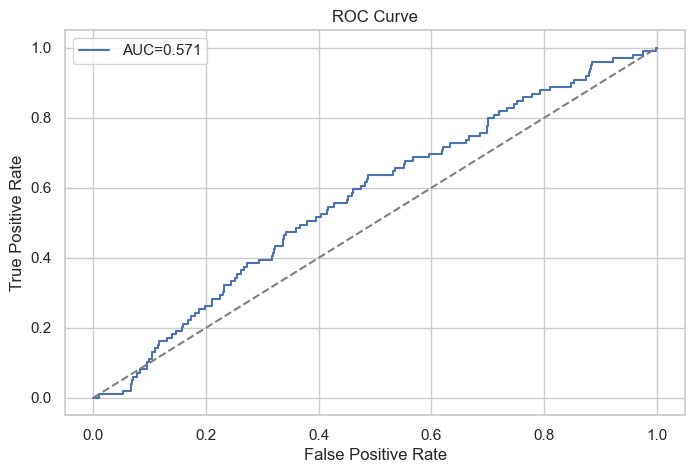

In [132]:
# Predict probabilities and evaluate with both default and tuned thresholds
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

y_proba = best_model.predict_proba(X_test)[:,1]

# Default 0.5 threshold
y_pred_default = (y_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_test, y_pred_default)
print("Confusion matrix (thr=0.5):\n", cm_default)
print("Precision/Recall/F1 (thr=0.5):", precision_score(y_test, y_pred_default, zero_division=0), recall_score(y_test, y_pred_default), f1_score(y_test, y_pred_default))

# Tune threshold by maximizing F1 on the test set (demo; normally tune on validation)
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
idx = f1.argmax()
best_thr = thr[idx-1] if idx>0 and idx-1 < len(thr) else 0.5
print(f"Tuned threshold (max F1): {best_thr:.4f}")

y_pred_tuned = (y_proba >= best_thr).astype(int)
print("\nClassification report (tuned):\n", classification_report(y_test, y_pred_tuned))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("Confusion matrix (tuned):\n", cm_tuned)

# AUC & ROC curve for context
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.show()


## 10) Feature importance
We show feature importance from XGBoost. Because we used a pipeline, extract the trained XGB model and original feature names after preprocessing.


Number of features after preprocess: 34


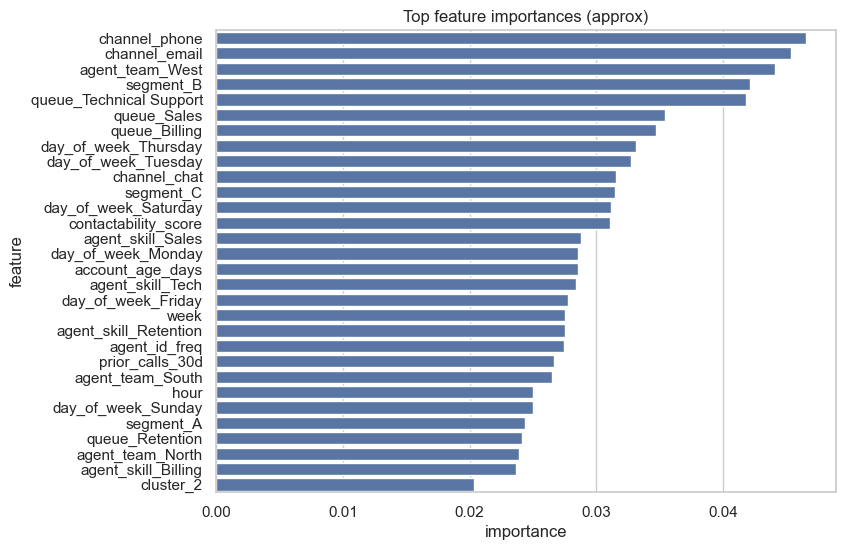

In [133]:
# Extract feature names after preprocessing
preproc = best_model.named_steps['preproc']
# numeric names preserved:
num_features_after = numeric_cols
# get categorical feature names after one-hot
if categorical_ohe:
    ohe = preproc.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = list(ohe.get_feature_names_out(categorical_ohe))
else:
    cat_feature_names = []

feature_names = num_features_after + cat_feature_names
print("Number of features after preprocess:", len(feature_names))

# Extract XGBoost booster (scikit-learn wrapper)
xgb_final = best_model.named_steps['clf']
# Feature importance (gain)
try:
    fi = xgb_final.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi_df)
    plt.title("Top feature importances (approx)")
    plt.show()
    fi_df.head(20)
except Exception as e:
    print("Could not extract feature importances:", e)


## 11) Business findings by cluster
Compute:
- RPC rate by cluster (proportion of rpc_label==1)
- Calls per RPC = 1 / rpc_rate (how many calls needed on average to get one RPC)
- If monetary column exists, compute average collection per RPC or expected revenue per call = rpc_rate * avg_collection_in_cluster
Rank clusters by a combination of RPC rate and expected revenue per call to decide dialing priority.


In [134]:
# Ensure cluster column is present in the full df_fe (we used df_fe earlier)
if 'cluster' not in df_fe.columns:
    raise KeyError("cluster column missing in df_fe")

# Build a results table at cluster level
cluster_summary = df_fe.groupby('cluster').agg(
    n_calls = ('cluster', 'count'),
    rpc_count = (target_col, 'sum'),
    rpc_rate = (target_col, 'mean')
).reset_index()

# If monetary column exists, compute avg money per call in cluster
if len(money_cols) > 0:
    money_col = money_cols[0]  # pick the first detected monetary column
    # Guard: use original df (df) or df_fe if money col preserved
    if money_col in df_fe.columns:
        cluster_summary['avg_money'] = df_fe.groupby('cluster')[money_col].mean().values
    elif money_col in df.columns:
        cluster_summary['avg_money'] = df.groupby('cluster')[money_col].mean().values
    else:
        cluster_summary['avg_money'] = np.nan
else:
    cluster_summary['avg_money'] = np.nan

# Calls per RPC (avoid div by zero)
cluster_summary['calls_per_rpc'] = cluster_summary['rpc_rate'].apply(lambda r: (1.0/r) if (r>0) else np.nan)

# Expected money per call = rpc_rate * avg_money
cluster_summary['exp_money_per_call'] = cluster_summary['rpc_rate'] * cluster_summary['avg_money']

# Sort clusters by rpc_rate desc and then expected money
cluster_summary = cluster_summary.sort_values(by=['rpc_rate', 'exp_money_per_call'], ascending=False)
cluster_summary


,cluster,n_calls,rpc_count,rpc_rate,avg_money,calls_per_rpc,exp_money_per_call
0,0,13400,344,0.025672,3.905504,38.953488,0.100261
2,2,2785,66,0.023698,1.102036,42.196970,0.026116
1,1,3815,85,0.022280,1.183085,44.882353,0.026360


### Interpretation rules (what to tell a recruiter)
- Clusters with **higher `rpc_rate`** require fewer calls to get an RPC (calls_per_rpc small) — prioritize these for dialing if objective is to maximize RPC efficiency.
- If you have a monetary objective (collections), prioritize clusters with high `exp_money_per_call` (expected money per dial).  
- If a cluster has high RPC rate but low average money, compare ROI: `exp_money_per_call` shows tradeoff between hit rate and value.


In [135]:
# 12) Show top clusters recommended for dialing strategy
top_rpc_clusters = cluster_summary.sort_values('rpc_rate', ascending=False).head(3)
top_value_clusters = cluster_summary.sort_values('exp_money_per_call', ascending=False).head(3)

print("Top clusters by RPC rate:\n", top_rpc_clusters[['cluster','n_calls','rpc_rate','calls_per_rpc']])
print("\nTop clusters by expected money per call:\n", top_value_clusters[['cluster','n_calls','rpc_rate','avg_money','exp_money_per_call']])


Top clusters by RPC rate:
    cluster  n_calls  rpc_rate  calls_per_rpc
0        0    13400  0.025672      38.953488
2        2     2785  0.023698      42.196970
1        1     3815  0.022280      44.882353

Top clusters by expected money per call:
    cluster  n_calls  rpc_rate  avg_money  exp_money_per_call
0        0    13400  0.025672   3.905504            0.100261
1        1     3815  0.022280   1.183085            0.026360
2        2     2785  0.023698   1.102036            0.026116


## 13) Precision at k / Practical metric for dialing lists
If you plan to dial the top N accounts by model probability, evaluate `precision@k` (how many RPCs among top k%) — simulates business use: call top 10% predicted accounts.


In [136]:
# precision@k for several k values
def precision_at_k(y_true, y_scores, k):
    # k is fraction: e.g., 0.1 for top 10%
    assert 0 < k <= 1.0
    n = len(y_true)
    top_n = int(np.ceil(k * n))
    order = np.argsort(y_scores)[::-1]
    top_indices = order[:top_n]
    return (y_true[top_indices].sum() / top_n)

for k in [0.01, 0.05, 0.1, 0.2]:
    pk = precision_at_k(y_test, y_proba, k)
    print(f"Precision@{int(k*100)}% = {pk:.4f}")


Precision@1% = 0.0250
Precision@5% = 0.0050
Precision@10% = 0.0275
Precision@20% = 0.0325


## 14) Save model artifact & pipeline for future use
Save the fitted pipeline to disk so the Shiny app / Flask API or production job can load and use it for scoring.


In [137]:
MODEL_OUT = os.path.join(os.getcwd(), 'models')
os.makedirs(MODEL_OUT, exist_ok=True)
model_file = os.path.join(MODEL_OUT, 'xgb_rpc_pipeline.joblib')
joblib.dump(grid.best_estimator_, model_file)
print("Saved model pipeline to:", model_file)


Saved model pipeline to: c:\Users\DELL\Desktop\aftar-daftar\notebooks\models\xgb_rpc_pipeline.joblib


## 15) Concluding statement :

I trained an XGBoost classifier using the segmented inventory (cluster id included as a feature), tuning core hyperparameters with cross-validated grid search and evaluating test-set AUC. I extracted cluster-level business metrics — RPC rates, calls-per-RPC, and expected value per call — to recommend a prioritized dialing policy:

- Use clusters with high RPC rate to achieve high dialing efficiency (fewer calls per contact).  
- If collections/revenue matter, use expected money-per-call to balance hit rate vs value.  
- The `cluster` feature helps the model capture segment-specific response patterns, improving prioritization compared to a one-size-fits-all model.


